In [ ]:
!pip install transformers torchmetrics

import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from transformers import ViTForImageClassification, AdamW
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm.auto import tqdm
from google.colab import drive
import random

# Mount Google Drive
drive.mount('/content/drive')

# Define paths to your dataset
train_path = '/content/drive/My Drive/Colab Notebooks/private-data/image/dataset/train'
valid_path = '/content/drive/My Drive/Colab Notebooks/private-data/image/dataset/val'
test_path = '/content/drive/My Drive/Colab Notebooks/private-data/image/dataset/test'

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load datasets
train_ds = datasets.ImageFolder(train_path, transform=transform)
valid_ds = datasets.ImageFolder(valid_path, transform=transform)
test_ds = datasets.ImageFolder(test_path, transform=transform)

# Hyperparameter setup for Random Search
learning_rate_choices = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
batch_size_choices = [8, 16, 32, 64]
num_trials = 10
num_epochs = 20
best_accuracy = 0

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Random Search Loop
for trial in range(num_trials):
    lr = random.choice(learning_rate_choices)
    batch_size = random.choice(batch_size_choices)

    print(f"Trial {trial+1}/{num_trials}: lr={lr}, batch_size={batch_size}")

    # Data loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # Model initialization
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(train_ds.classes))
    model.to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=lr)

    # Early stopping variables
    best_val_loss = float('inf')
    epochs_no_improve = 0
    early_stop_patience = 3

    # Training and validation
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct_predictions = 0, 0
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct_predictions / len(train_ds)

        model.eval()
        total_loss, correct_predictions = 0, 0
        with torch.no_grad():
            for images, labels in tqdm(valid_loader, desc="Validating"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_predictions += (predicted == labels).sum().item()

        valid_loss = total_loss / len(valid_loader)
        valid_accuracy = correct_predictions / len(valid_ds)

        # Early stopping logic
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), f'/content/drive/My Drive/Colab Notebooks/private-data/models/best_vit_model_{trial}.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stop_patience:
                print("Early stopping triggered")
                break

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {valid_loss:.4f}, Val Acc: {valid_accuracy:.4f}")

# Load and evaluate the best model
model.load_state_dict(torch.load(f'/content/drive/My Drive/Colab Notebooks/private-data/models/best_vit_model_{trial}.pth'))
model.eval()
total_loss, correct_predictions = 0, 0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        loss = criterion(outputs, labels)

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()

test_loss = total_loss / len(test_loader)
test_accuracy = correct_predictions / len(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Trial 1/10: lr=1e-05, batch_size=32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 1.3356, Train Acc: 0.4354, Val Loss: 1.2849, Val Acc: 0.6154


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 1.1989, Train Acc: 0.7585, Val Loss: 1.1919, Val Acc: 0.7500


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 1.0716, Train Acc: 0.8707, Val Loss: 1.1002, Val Acc: 0.8173


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.9389, Train Acc: 0.9305, Val Loss: 1.0006, Val Acc: 0.8462


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.8081, Train Acc: 0.9585, Val Loss: 0.8911, Val Acc: 0.8654


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.6800, Train Acc: 0.9707, Val Loss: 0.7804, Val Acc: 0.8942


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 0.5591, Train Acc: 0.9720, Val Loss: 0.6761, Val Acc: 0.9231


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 0.4586, Train Acc: 0.9829, Val Loss: 0.5813, Val Acc: 0.9231


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 0.3743, Train Acc: 0.9902, Val Loss: 0.5078, Val Acc: 0.9231


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.3098, Train Acc: 0.9963, Val Loss: 0.4432, Val Acc: 0.9423


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 0.2583, Train Acc: 0.9988, Val Loss: 0.3968, Val Acc: 0.9423


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 0.2186, Train Acc: 0.9988, Val Loss: 0.3586, Val Acc: 0.9519


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 0.1871, Train Acc: 0.9988, Val Loss: 0.3341, Val Acc: 0.9519


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/20], Train Loss: 0.1625, Train Acc: 0.9988, Val Loss: 0.3015, Val Acc: 0.9519


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/20], Train Loss: 0.1425, Train Acc: 1.0000, Val Loss: 0.2784, Val Acc: 0.9519


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/20], Train Loss: 0.1268, Train Acc: 1.0000, Val Loss: 0.2708, Val Acc: 0.9519


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/20], Train Loss: 0.1142, Train Acc: 1.0000, Val Loss: 0.2599, Val Acc: 0.9423


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/20], Train Loss: 0.1037, Train Acc: 1.0000, Val Loss: 0.2426, Val Acc: 0.9519


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/20], Train Loss: 0.0946, Train Acc: 1.0000, Val Loss: 0.2376, Val Acc: 0.9615


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/20], Train Loss: 0.0872, Train Acc: 1.0000, Val Loss: 0.2256, Val Acc: 0.9519
Trial 2/10: lr=5e-05, batch_size=64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 1.2647, Train Acc: 0.5463, Val Loss: 1.1387, Val Acc: 0.6731


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 0.9342, Train Acc: 0.9000, Val Loss: 0.8775, Val Acc: 0.8558


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 0.6395, Train Acc: 0.9280, Val Loss: 0.6286, Val Acc: 0.9038


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.3971, Train Acc: 0.9659, Val Loss: 0.4307, Val Acc: 0.9231


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.2427, Train Acc: 0.9915, Val Loss: 0.3259, Val Acc: 0.9327


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.1564, Train Acc: 0.9963, Val Loss: 0.2592, Val Acc: 0.9327


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 0.1073, Train Acc: 1.0000, Val Loss: 0.2455, Val Acc: 0.9423


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 0.0825, Train Acc: 1.0000, Val Loss: 0.2257, Val Acc: 0.9327


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 0.0680, Train Acc: 1.0000, Val Loss: 0.2087, Val Acc: 0.9327


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.0592, Train Acc: 1.0000, Val Loss: 0.2244, Val Acc: 0.9327


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 0.0530, Train Acc: 1.0000, Val Loss: 0.2203, Val Acc: 0.9327


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered
Trial 3/10: lr=0.001, batch_size=32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 1.3393, Train Acc: 0.3220, Val Loss: 1.3457, Val Acc: 0.3654


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 1.3159, Train Acc: 0.3902, Val Loss: 1.3616, Val Acc: 0.3942


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 1.3656, Train Acc: 0.3305, Val Loss: 1.3974, Val Acc: 0.2500


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 1.3504, Train Acc: 0.2963, Val Loss: 1.3266, Val Acc: 0.2981


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 1.2404, Train Acc: 0.4085, Val Loss: 1.2914, Val Acc: 0.4231


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 1.2127, Train Acc: 0.4463, Val Loss: 1.2937, Val Acc: 0.4231


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 1.1805, Train Acc: 0.4683, Val Loss: 1.3242, Val Acc: 0.4231


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 1.1857, Train Acc: 0.4610, Val Loss: 1.2758, Val Acc: 0.4135


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 1.1790, Train Acc: 0.4585, Val Loss: 1.3735, Val Acc: 0.4038


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 1.1817, Train Acc: 0.4549, Val Loss: 1.2959, Val Acc: 0.4519


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Early stopping triggered
Trial 4/10: lr=0.0001, batch_size=8


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.7358, Train Acc: 0.7829, Val Loss: 0.3908, Val Acc: 0.8846


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 0.1594, Train Acc: 0.9707, Val Loss: 0.3066, Val Acc: 0.9135


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 0.0865, Train Acc: 0.9841, Val Loss: 0.2917, Val Acc: 0.8942


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.0630, Train Acc: 0.9890, Val Loss: 0.1245, Val Acc: 0.9423


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.0765, Train Acc: 0.9829, Val Loss: 0.3033, Val Acc: 0.8942


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.0349, Train Acc: 0.9951, Val Loss: 0.2537, Val Acc: 0.9135


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Early stopping triggered
Trial 5/10: lr=5e-05, batch_size=64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 1.2372, Train Acc: 0.6244, Val Loss: 1.1183, Val Acc: 0.7500


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 0.9047, Train Acc: 0.9159, Val Loss: 0.8573, Val Acc: 0.8558


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 0.6064, Train Acc: 0.9585, Val Loss: 0.6144, Val Acc: 0.8846


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.3704, Train Acc: 0.9805, Val Loss: 0.4323, Val Acc: 0.9038


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.2205, Train Acc: 0.9939, Val Loss: 0.2912, Val Acc: 0.9327


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.1384, Train Acc: 1.0000, Val Loss: 0.2233, Val Acc: 0.9615


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 0.0964, Train Acc: 1.0000, Val Loss: 0.1923, Val Acc: 0.9519


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 0.0756, Train Acc: 1.0000, Val Loss: 0.1777, Val Acc: 0.9615


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 0.0633, Train Acc: 1.0000, Val Loss: 0.1799, Val Acc: 0.9519


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.0554, Train Acc: 1.0000, Val Loss: 0.1816, Val Acc: 0.9423


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 0.0497, Train Acc: 1.0000, Val Loss: 0.1720, Val Acc: 0.9519


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 0.0452, Train Acc: 1.0000, Val Loss: 0.1799, Val Acc: 0.9423


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 0.0416, Train Acc: 1.0000, Val Loss: 0.1810, Val Acc: 0.9423


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered
Trial 6/10: lr=0.001, batch_size=8


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 1.3038, Train Acc: 0.3707, Val Loss: 1.3142, Val Acc: 0.4038


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 1.2256, Train Acc: 0.4341, Val Loss: 1.3244, Val Acc: 0.3846


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 1.3342, Train Acc: 0.3366, Val Loss: 1.3331, Val Acc: 0.4038


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Early stopping triggered
Trial 7/10: lr=1e-05, batch_size=64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 1.3610, Train Acc: 0.3610, Val Loss: 1.3245, Val Acc: 0.5481


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 1.2747, Train Acc: 0.6402, Val Loss: 1.2660, Val Acc: 0.6346


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 1.1929, Train Acc: 0.7854, Val Loss: 1.2077, Val Acc: 0.7404


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 1.1100, Train Acc: 0.8732, Val Loss: 1.1455, Val Acc: 0.8077


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 1.0257, Train Acc: 0.9280, Val Loss: 1.0775, Val Acc: 0.8173


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.9390, Train Acc: 0.9415, Val Loss: 1.0068, Val Acc: 0.8365


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 0.8526, Train Acc: 0.9524, Val Loss: 0.9340, Val Acc: 0.8462


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 0.7676, Train Acc: 0.9646, Val Loss: 0.8675, Val Acc: 0.8558


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 0.6867, Train Acc: 0.9707, Val Loss: 0.7989, Val Acc: 0.8654


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.6103, Train Acc: 0.9744, Val Loss: 0.7366, Val Acc: 0.8654


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 0.5404, Train Acc: 0.9805, Val Loss: 0.6800, Val Acc: 0.8750


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 0.4790, Train Acc: 0.9829, Val Loss: 0.6270, Val Acc: 0.8846


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 0.4225, Train Acc: 0.9866, Val Loss: 0.5745, Val Acc: 0.9038


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/20], Train Loss: 0.3737, Train Acc: 0.9890, Val Loss: 0.5350, Val Acc: 0.9038


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/20], Train Loss: 0.3315, Train Acc: 0.9939, Val Loss: 0.4928, Val Acc: 0.9135


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/20], Train Loss: 0.2944, Train Acc: 0.9939, Val Loss: 0.4559, Val Acc: 0.9135


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/20], Train Loss: 0.2628, Train Acc: 0.9951, Val Loss: 0.4254, Val Acc: 0.9038


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/20], Train Loss: 0.2351, Train Acc: 0.9976, Val Loss: 0.3969, Val Acc: 0.9038


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/20], Train Loss: 0.2115, Train Acc: 0.9976, Val Loss: 0.3722, Val Acc: 0.9038


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/20], Train Loss: 0.1917, Train Acc: 0.9976, Val Loss: 0.3575, Val Acc: 0.9038
Trial 8/10: lr=1e-05, batch_size=64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 1.3583, Train Acc: 0.3512, Val Loss: 1.3426, Val Acc: 0.4135


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 1.2654, Train Acc: 0.5805, Val Loss: 1.2849, Val Acc: 0.5865


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 1.1824, Train Acc: 0.7415, Val Loss: 1.2266, Val Acc: 0.6827


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 1.0992, Train Acc: 0.8183, Val Loss: 1.1673, Val Acc: 0.7212


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 1.0198, Train Acc: 0.8817, Val Loss: 1.1048, Val Acc: 0.7404


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.9353, Train Acc: 0.9134, Val Loss: 1.0356, Val Acc: 0.8077


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 0.8530, Train Acc: 0.9378, Val Loss: 0.9701, Val Acc: 0.8077


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 0.7716, Train Acc: 0.9476, Val Loss: 0.9000, Val Acc: 0.8077


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 0.6944, Train Acc: 0.9549, Val Loss: 0.8351, Val Acc: 0.8173


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.6196, Train Acc: 0.9683, Val Loss: 0.7680, Val Acc: 0.8462


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 0.5501, Train Acc: 0.9744, Val Loss: 0.7059, Val Acc: 0.8558


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 0.4874, Train Acc: 0.9805, Val Loss: 0.6507, Val Acc: 0.8654


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 0.4297, Train Acc: 0.9817, Val Loss: 0.5986, Val Acc: 0.8750


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/20], Train Loss: 0.3781, Train Acc: 0.9890, Val Loss: 0.5487, Val Acc: 0.9038


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/20], Train Loss: 0.3346, Train Acc: 0.9915, Val Loss: 0.5062, Val Acc: 0.9135


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/20], Train Loss: 0.2961, Train Acc: 0.9963, Val Loss: 0.4682, Val Acc: 0.9135


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/20], Train Loss: 0.2633, Train Acc: 0.9988, Val Loss: 0.4325, Val Acc: 0.9231


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/20], Train Loss: 0.2353, Train Acc: 0.9988, Val Loss: 0.4044, Val Acc: 0.9231


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/20], Train Loss: 0.2110, Train Acc: 0.9988, Val Loss: 0.3783, Val Acc: 0.9231


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/20], Train Loss: 0.1910, Train Acc: 0.9988, Val Loss: 0.3597, Val Acc: 0.9327
Trial 9/10: lr=0.0001, batch_size=64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 1.1421, Train Acc: 0.6463, Val Loss: 0.9238, Val Acc: 0.8077


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 0.6131, Train Acc: 0.9415, Val Loss: 0.4909, Val Acc: 0.9038


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 0.2778, Train Acc: 0.9780, Val Loss: 0.2852, Val Acc: 0.9038


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.1299, Train Acc: 0.9988, Val Loss: 0.1958, Val Acc: 0.9519


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.0778, Train Acc: 1.0000, Val Loss: 0.1580, Val Acc: 0.9615


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.0576, Train Acc: 1.0000, Val Loss: 0.1847, Val Acc: 0.9423


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 0.0470, Train Acc: 1.0000, Val Loss: 0.1459, Val Acc: 0.9615


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 0.0398, Train Acc: 1.0000, Val Loss: 0.1371, Val Acc: 0.9712


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 0.0348, Train Acc: 1.0000, Val Loss: 0.1544, Val Acc: 0.9519


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.0310, Train Acc: 1.0000, Val Loss: 0.1497, Val Acc: 0.9519


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered
Trial 10/10: lr=0.0001, batch_size=8


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.7695, Train Acc: 0.7537, Val Loss: 0.3249, Val Acc: 0.9423


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 0.1652, Train Acc: 0.9695, Val Loss: 0.1917, Val Acc: 0.9423


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 0.1099, Train Acc: 0.9756, Val Loss: 0.1286, Val Acc: 0.9423


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.0276, Train Acc: 0.9988, Val Loss: 0.0801, Val Acc: 0.9712


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.0429, Train Acc: 0.9878, Val Loss: 0.2863, Val Acc: 0.9231


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.0651, Train Acc: 0.9780, Val Loss: 0.1205, Val Acc: 0.9615


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Early stopping triggered


Testing:   0%|          | 0/13 [00:00<?, ?it/s]

Test Loss: 0.2677, Test Accuracy: 0.9320


Performance Evaluation

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Test Loss: 0.2677
Test Accuracy: 0.9320
 Precision: 0.9332
 Recall: 0.9315
 F1 Score: 0.9319


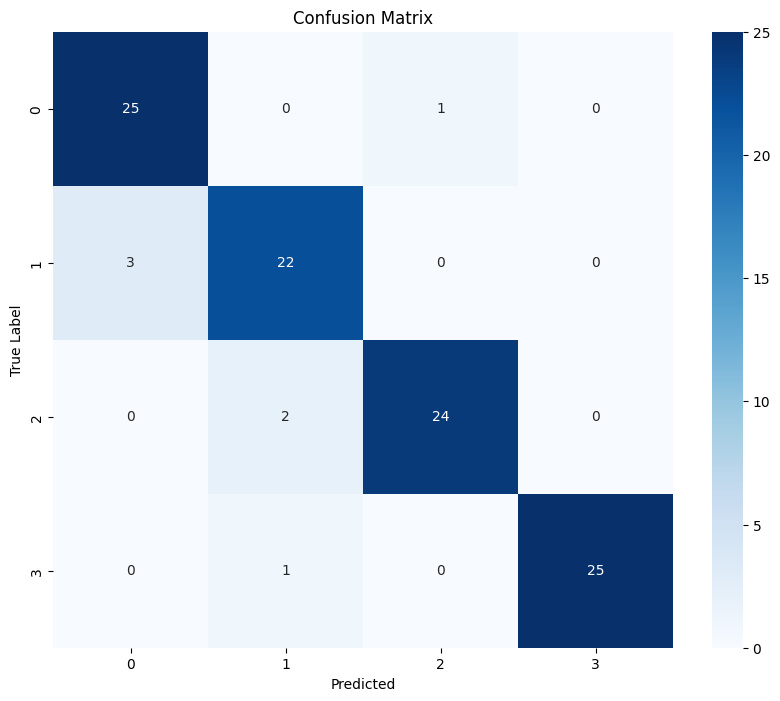

In [ ]:
import torch
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = correct_predictions / len(loader.dataset)

    # Compute metrics
    precision = precision_score(all_true_labels, all_predictions, average='macro')
    recall = recall_score(all_true_labels, all_predictions, average='macro')
    f1 = f1_score(all_true_labels, all_predictions, average='macro')

    # Compute confusion matrix
    conf_mat = confusion_matrix(all_true_labels, all_predictions)

    return avg_loss, accuracy, precision, recall, f1, conf_mat

# Evaluate on the test set
test_loss, test_accuracy, test_precision, test_recall, test_f1, conf_mat = evaluate(model, test_loader, criterion, device)

# Print the metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f" Precision: {test_precision:.4f}")
print(f" Recall: {test_recall:.4f}")
print(f" F1 Score: {test_f1:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Class 0 - Precision: 0.8929, Recall: 0.9615, F1: 0.9259, Accuracy: 0.9612


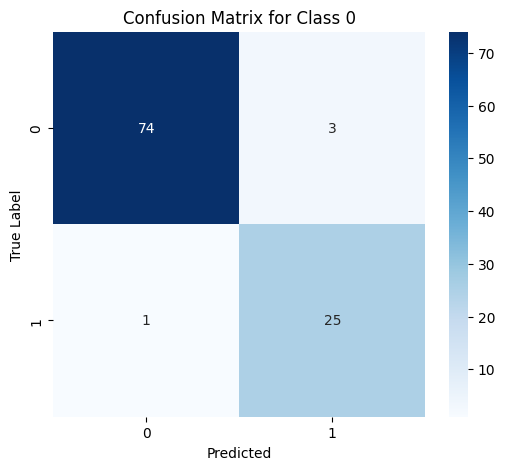

Class 1 - Precision: 0.8800, Recall: 0.8800, F1: 0.8800, Accuracy: 0.9417


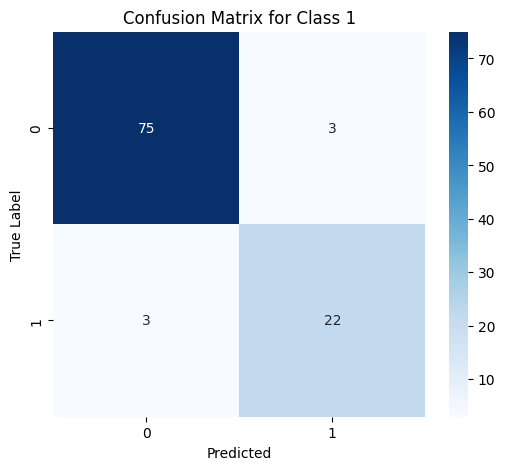

Class 2 - Precision: 0.9600, Recall: 0.9231, F1: 0.9412, Accuracy: 0.9709


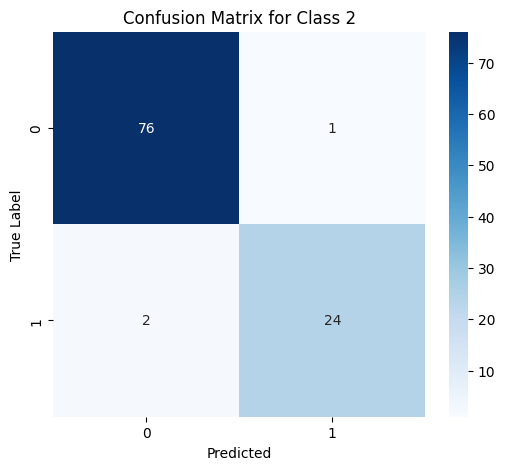

Class 3 - Precision: 1.0000, Recall: 0.9615, F1: 0.9804, Accuracy: 0.9903


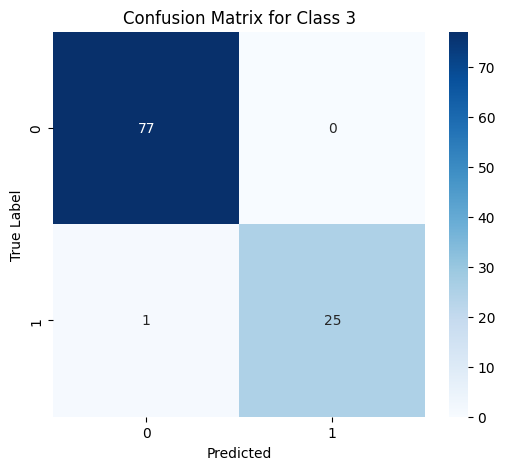

In [ ]:
import torch
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluation function
def evaluate_per_class(model, loader, criterion, device, num_classes):
    model.eval()
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(inputs).logits
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    metrics_per_class = {}
    conf_matrices = {}

    for class_index in range(num_classes):
        # Treat each class as binary (class vs. not class)
        binary_true = (np.array(all_true_labels) == class_index).astype(int)
        binary_pred = (np.array(all_predictions) == class_index).astype(int)

        # Calculate metrics
        precision = precision_score(binary_true, binary_pred)
        recall = recall_score(binary_true, binary_pred)
        f1 = f1_score(binary_true, binary_pred)
        accuracy = accuracy_score(binary_true, binary_pred)

        # Compute confusion matrix
        conf_mat = confusion_matrix(binary_true, binary_pred)

        metrics_per_class[class_index] = {'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy}
        conf_matrices[class_index] = conf_mat

    return metrics_per_class, conf_matrices

# Number of classes
num_classes = 4
# Evaluate on the test set
metrics_per_class, conf_matrices = evaluate_per_class(model, test_loader, criterion, device, num_classes)

# Print metrics and plot confusion matrices
for class_index in range(num_classes):
    metrics = metrics_per_class[class_index]
    print(f"Class {class_index} - Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}, Accuracy: {metrics['accuracy']:.4f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrices[class_index], annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Class {class_index}')
    plt.show()


ROC-AUC

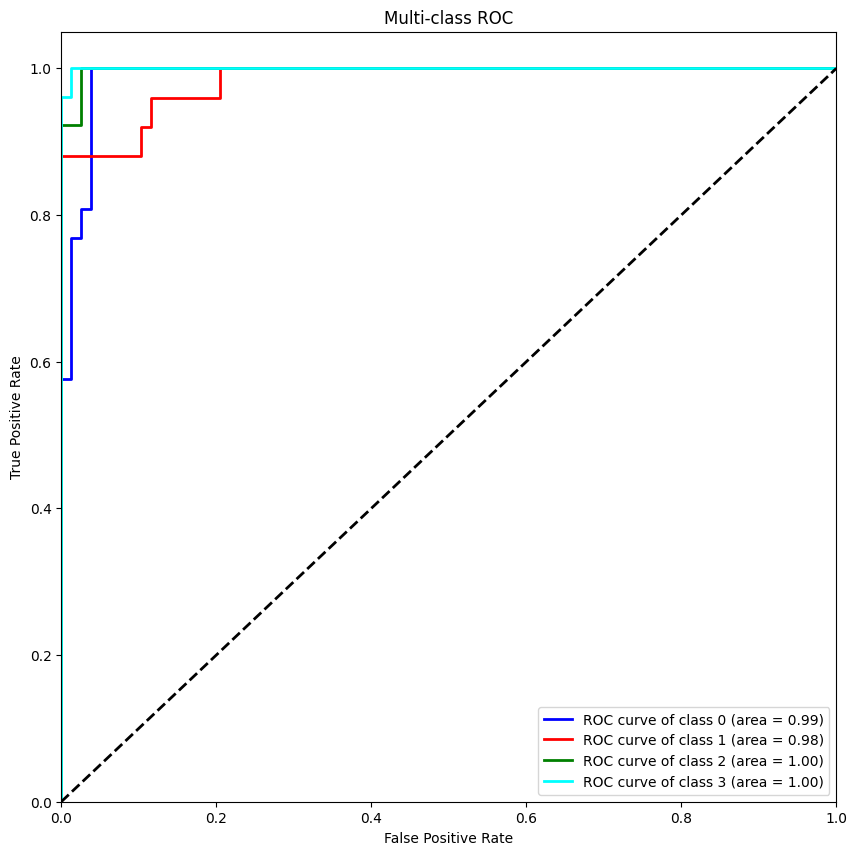

In [ ]:
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import torch
def evaluate_and_get_predictions(model, loader, device, n_classes):
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs).logits
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            all_preds.append(probabilities.cpu().numpy())
            all_true.append(labels.cpu().numpy())

    # Binarize the labels
    all_true_bin = label_binarize(np.concatenate(all_true), classes=range(n_classes))
    return all_true_bin, np.concatenate(all_preds)

# Get the test data predictions and true labels
n_classes = len(train_ds.classes)
y_test_bin, y_score = evaluate_and_get_predictions(model, test_loader, device, n_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown'])
plt.figure(figsize=(10, 10))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()
